In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
#from MODULES.utilities_ml import FiniteDPP, SimilarityKernel

### Copy the function here to make this notebook self contained

In [6]:
from typing import Optional
from torch.distributions.distribution import Distribution
from torch.distributions import constraints

class SimilarityKernel(torch.nn.Module):
    """ Similarity based on sum of gaussian kernels of different strength and length_scales """
    def __init__(self, n_kernels: int = 4,
                 pbc: bool = False,
                 eps: float = 1E-4,
                 length_scales: Optional[torch.Tensor] = None,
                 kernel_weights: Optional[torch.Tensor] = None):
        """ It is safer to set pbc=False b/c the matrix might become ill-conditioned otherwise """
        super().__init__()

        self.n_kernels = n_kernels
        self.eps = eps
        self.pbc = pbc
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        if length_scales is None:
            LENGTH_2 = 10.0
            length_scales = torch.linspace(LENGTH_2/self.n_kernels, LENGTH_2,
                                           steps=self.n_kernels,
                                           device=self.device,
                                           dtype=torch.float)
        else:
            length_scales = self._invertsoftplus(length_scales.float().to(self.device))
        assert length_scales.shape[0] == self.n_kernels
        self.similarity_length = torch.nn.Parameter(data=length_scales, requires_grad=True)

        if kernel_weights is None:
            kernel_weights = torch.ones(self.n_kernels,
                                        device=self.device,
                                        dtype=torch.float)/self.n_kernels
        else:
            kernel_weights = self._invertsoftplus(kernel_weights.float().to(self.device))
        assert kernel_weights.shape[0] == self.n_kernels
        self.similarity_w = torch.nn.Parameter(data=kernel_weights, requires_grad=True)

        # Initialization
        self.n_width = -1
        self.n_height = -1
        self.d2 = None
        self.diag = None

    @staticmethod
    def _invertsoftplus(x):
        return torch.log(torch.exp(x)-1.0)

    def _compute_d2_diag(self, n_width: int, n_height: int):
        with torch.no_grad():
            ix_array = torch.arange(start=0, end=n_width, dtype=torch.int, device=self.device)
            iy_array = torch.arange(start=0, end=n_height, dtype=torch.int, device=self.device)
            ix_grid, iy_grid = torch.meshgrid([ix_array, iy_array])
            map_points = torch.stack((ix_grid, iy_grid), dim=-1)  # n_width, n_height, 2
            locations = map_points.flatten(start_dim=0, end_dim=-2)  # (n_width*n_height, 2)
            d = (locations.unsqueeze(-2) - locations.unsqueeze(-3)).abs()  # (n_width*n_height, n_width*n_height, 2)
            if self.pbc:
                d_pbc = d.clone()
                d_pbc[..., 0] = -d[..., 0] + n_width
                d_pbc[..., 1] = -d[..., 1] + n_height
                d2 = torch.min(d, d_pbc).pow(2).sum(dim=-1).float()
            else:
                d2 = d.pow(2).sum(dim=-1).float()

            values = self.eps * torch.ones(d2.shape[-2], dtype=torch.float, device=self.device)
            diag = torch.diag_embed(values, offset=0, dim1=-2, dim2=-1)
            return d2, diag

    def sample_2_mask(self, sample):
        independent_dims = list(sample.shape[:-1])
        mask = sample.view(independent_dims + [self.n_width, self.n_height])
        return mask

    def get_l_w(self):
        return F.softplus(self.similarity_length)+1.0, F.softplus(self.similarity_w)+1E-2

    def forward(self, n_width: int, n_height: int):
        """ Implement L = sum_i a_i exp[-b_i d2] """
        l, w = self.get_l_w()
        l2 = l.pow(2)

        if (n_width != self.n_width) or (n_height != self.n_height):
            self.n_width = n_width
            self.n_height = n_height
            self.d2, self.diag = self._compute_d2_diag(n_width=n_width, n_height=n_height)

        likelihood_kernel = (w[..., None, None] *
                             torch.exp(-0.5*self.d2/l2[..., None, None])).sum(dim=-3) + self.diag
        return likelihood_kernel  # shape (n_width*n_height, n_width*n_height)

class FiniteDPP(Distribution):
    """ Finite DPP distribution defined via:
        1. L = likelihood kernel of shape *,n,n
        2. K = correlation kernel of shape *,n,n

        The constraints are:
        K = positive semidefinite, symmetric, eigenvalues in [0,1]
        L = positive semidefinite, symmetric, eigenvalues >= 0

        Need to be careful about svd decomposition which can become unstable on GPU or CPU
        https://github.com/pytorch/pytorch/issues/28293
    """

    arg_constraints = {'K': constraints.positive_definite,
                       'L': constraints.positive_definite}
    support = constraints.boolean
    has_rsample = False

    def __init__(self, K=None, L=None, validate_args=None):

        if (K is None and L is None) or (K is not None and L is not None):
            raise Exception("only one among K and L need to be defined")

        elif K is not None:
            self.K = 0.5 * (K + K.transpose(-1, -2))  # make sure it is symmetrized
            try:
                u, s_k, v = torch.svd(self.K)
            except:
                # torch.svd may have convergence issues for GPU and CPU.
                u, s_k, v = torch.svd(self.K + 1e-3 * self.K.mean() * torch.ones_like(self.K))
            s_l = s_k / (1.0 - s_k)
            self.L = torch.matmul(u * s_l.unsqueeze(-2), v.transpose(-1, -2))

            # Debug block
            # tmp = torch.matmul(u * s_k.unsqueeze(-2), v.transpose(-1, -2))
            # check = (tmp - self.K).abs().max()
            # print("check ->",check)
            # assert check < 1E-4

        elif L is not None:
            self.L = 0.5 * (L + L.transpose(-1, -2))  # make sure it is symmetrized
            try:
                u, s_l, v = torch.svd(self.L)
            except:
                # torch.svd may have convergence issues for GPU and CPU.
                u, s_l, v = torch.svd(self.L + 1e-3 * self.L.mean() * torch.ones_like(self.L))
            s_k = s_l / (1.0 + s_l)
            self.K = torch.matmul(u * s_k.unsqueeze(-2), v.transpose(-1, -2))

            # Debug block
            # tmp = torch.matmul(u * s_l.unsqueeze(-2), v.transpose(-1, -2))
            # check = (tmp - self.L).abs().max()
            # print("check ->",check)
            # assert check < 1E-4
        else:
            raise Exception

        self.s_l = s_l
        batch_shape, event_shape = self.K.shape[:-2], self.K.shape[-1:]
        super(FiniteDPP, self).__init__(batch_shape, event_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(FiniteDPP, _instance)
        batch_shape = torch.Size(batch_shape)
        kernel_shape = batch_shape + self.event_shape + self.event_shape
        value_shape = batch_shape + self.event_shape
        new.s_l = self.s_l.expand(value_shape)
        new.L = self.L.expand(kernel_shape)
        new.K = self.K.expand(kernel_shape)
        super(FiniteDPP, new).__init__(batch_shape,
                                       self.event_shape,
                                       validate_args=False)
        new._validate_args = self._validate_args
        return new

    def sample(self, sample_shape=torch.Size()):
        shape_value = self._extended_shape(sample_shape)  # shape = sample_shape + batch_shape + event_shape
        shape_kernel = shape_value + self._event_shape  # shape = sample_shape + batch_shape + event_shape + event_shape

        with torch.no_grad():
            K = self.K.expand(shape_kernel).clone()
            value = torch.zeros(shape_value, dtype=torch.bool, device=K.device)
            rand = torch.rand(shape_value, dtype=K.dtype, device=K.device)

            for j in range(rand.shape[-1]):
                c = rand[..., j] < K[..., j, j]
                value[..., j] = c
                K[..., j, j] -= (~c).to(K.dtype)
                K[..., j + 1:, j] /= K[..., j, j].unsqueeze(-1)
                K[..., j + 1:, j + 1:] -= K[..., j + 1:, j].unsqueeze(-1) * K[..., j, j + 1:].unsqueeze(-2)

            return value

    def log_prob(self, value):
        """ log_prob = logdet(Ls) - logdet(L+I)
            I am using the fact that eigen(L+I) = eigen(L)+1
            -> logdet(L+I)=log prod[ eigen(L+I) ] = sum log(eigen(L+I)) = sum log(eigen(L)+1)

            # value.shape = sample_shape + batch_shape + event_shape
            # logdet(L+I).shape = batch_shape
            :rtype:
        """
        assert are_broadcastable(value, self.L[..., 0])
        assert self.L.device == value.device
        assert value.dtype == torch.bool

        if self._validate_args:
            self._validate_sample(value)

        logdet_L_plus_I = (self.s_l + 1).log().sum(dim=-1)  # batch_shape

        # Reshapes
        independet_dims = list(value.shape[:-1])
        value = value.flatten(start_dim=0, end_dim=-2)  # *, event_shape
        L = self.L.expand(independet_dims + [-1, -1]).flatten(start_dim=0, end_dim=-3)  # *, event_shape, event_shape

        n_max = torch.sum(value, dim=-1).max().item()
        matrix = torch.eye(n_max, dtype=L.dtype, device=L.device).expand(L.shape[-3], n_max, n_max).clone()
        for i in range(value.shape[0]):
            n = torch.sum(value[i]).item()
            matrix[i, :n, :n] = L[i, value[i], :][:, value[i]]
        logdet_Ls = torch.logdet(matrix).view(independet_dims)  # sample_shape, batch_shape
        return logdet_Ls - logdet_L_plus_I

# Make fig of DPP

0 0 20 0.1
0 1 20 1
0 2 20 5
0 3 20 10
1 0 10 0.1
1 1 10 1
1 2 10 5
1 3 10 10
2 0 5 0.1
2 1 5 1
2 2 5 5
2 3 5 10
3 0 1 0.1
3 1 1 1
3 2 1 5
3 3 1 10


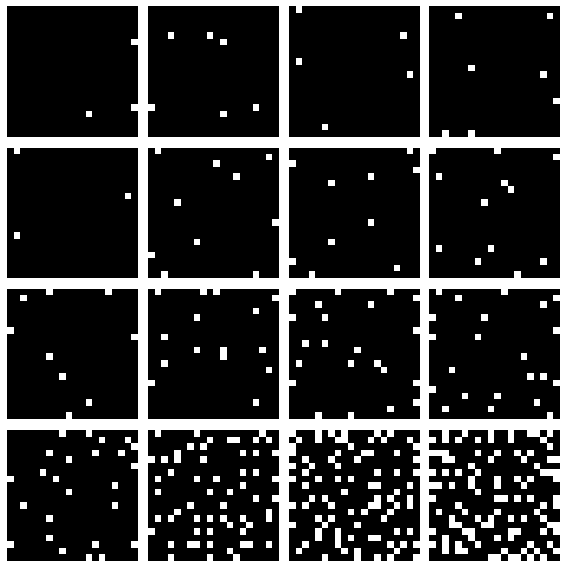

In [8]:
fig, ax =  plt.subplots(ncols=4, nrows=4, figsize=(8,8))
for r, length_scale in enumerate([20,10,5,1]):
    for c, prefactor in enumerate([0.1, 1, 5, 10]):
        print(r,c,length_scale,prefactor)
        
        similarity = SimilarityKernel(n_kernels=1, 
                                      length_scales=torch.tensor([length_scale]),
                                      kernel_weights=torch.tensor([prefactor]))
        L = similarity(n_width=20, n_height=20)
        DPP = FiniteDPP(L=L)
        value = DPP.sample(sample_shape=torch.Size([3]))  # draw three samples
        mask = similarity.sample_2_mask(value)
        ax[r,c].axis('off')
        ax[r,c].imshow(mask[0], cmap='gray')
fig.tight_layout()
fig.savefig("./DPP_samples.png")